In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

import time

# load the data
file_name = '-train-rgbs-new'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-ref/'
file_path = '../data/master-APOGEE-giants-train.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

# define the training set
train_ID = label_data['ids']
train_flux = spectra_data['fluxes']
train_flux_err = spectra_data['fluxes_err']
train_flux_ivar = spectra_data['fluxes_ivars']
train_label = label_data['labels']
train_label_err = label_data['labels_err']
train_label_ivar = label_data['labels_ivars']

../spec/spectra-reference-stars-APOGEE-giants-ref/spectra_data-train-rgbs-new.dat
File already exists. Loading spectra data


24it [00:00, 84.88it/s]

Loaded data successfully


In [2]:
train_ID = label_data['ids']
train_flux = spectra_data['fluxes']
train_flux_err = spectra_data['fluxes_err']
train_flux_ivar = spectra_data['fluxes_ivars']
train_label = label_data['labels']
train_label_err = label_data['labels_err']
train_label_ivar = label_data['labels_ivars']


# First run the optimisation assuming no scatters in the fluxes

In [3]:
P = 49
alphas, betas, zetas = il.initialise_alphas_betas_zetas(train_label, train_flux, P)
alphas.shape, betas.shape, zetas.shape

((12, 49), (8575, 49), (5000, 49))

In [4]:
niter = 5
alphas_iter = jnp.zeros((niter,) + alphas.shape)
betas_iter = jnp.zeros((niter,) + betas.shape)
zetas_iter = jnp.zeros((niter,) + zetas.shape)
diff_chi2_iter = jnp.zeros((niter))
chi2_iter = jnp.zeros((niter))

omega = 1.
for iter in tqdm.tqdm_notebook(range(niter)):
    alphas, betas, zetas, diff_chi2, chi2 = opt.run_agenda(alphas, betas, zetas, train_label, train_label_err, train_flux, train_flux_err, omega)
    alphas_iter = alphas_iter.at[iter].set(alphas)
    betas_iter = betas_iter.at[iter].set(betas)
    zetas_iter = zetas_iter.at[iter].set(zetas)
    diff_chi2_iter = diff_chi2_iter.at[iter].set(diff_chi2)
    chi2_iter = chi2_iter.at[iter].set(chi2)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_42849/141839097.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm.tqdm_notebook(range(niter)):


  0%|          | 0/5 [00:00<?, ?it/s]

# save the latents without scatters in the fluxes

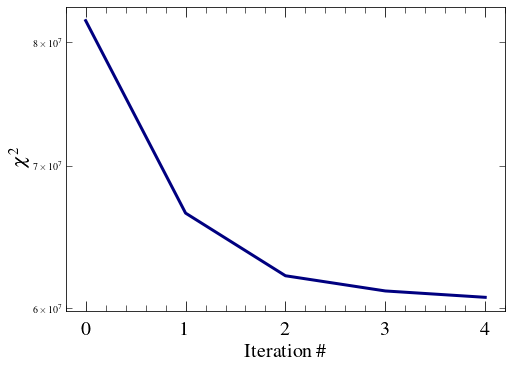

In [5]:
name = '_P49_omega1-train-highsnrgiants'
savepath = '../sav/paper/'

np.save(savepath+'alphas_giants'+str(name), alphas_iter)
np.save(savepath+'betas_giants'+str(name), betas_iter)
np.save(savepath+'diff_chi2_giants'+str(name), diff_chi2_iter)
np.save(savepath+'chi2_giants'+str(name), chi2_iter)
np.save(savepath+'zetas_train_giants'+str(name), zetas_iter)

plt.figure(figsize=(7,5), constrained_layout=True)

plt.plot(chi2_iter, color='navy', lw=3)
plt.ylabel('$\chi^{2}$', fontsize=20)
plt.xlabel('Iteration $\#$', fontsize=20)
plt.yscale('log')
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/chi2_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')

# now run the optimisation with scatter in the fluxes

In [6]:
ln_noise_fluxes_init = jnp.full(train_flux.shape[1], -8.0)
l2_reg_strength = 1000

In [7]:
# run optimisation routine with noise in the flux
betas_updated, zetas_updated, ln_noise_fluxes_updated, nll_updated = opt_sc.run_agenda(alphas, betas, zetas, train_label, train_label_ivar, train_flux, train_flux_ivar,\
                                            ln_noise_fluxes_init, l2_reg_strength, omega)


INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 173189922.43494996, Curvature error: 186009081776919.75
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 601933.5962584128, Curvature error: 646364650113.2821


In [8]:
name = '_P49_L2regstrength1000_omega1-train-highsnrgiants'
savepath = '../sav/paper/'

np.save(savepath+'alphas_giants-withscatters'+str(name), alphas)
np.save(savepath+'betas_giants-withscatters'+str(name), betas_updated)
np.save(savepath+'zetas_train_giants-withscatters'+str(name), zetas_updated)
np.save(savepath+'noise_fluxes_train_giants-withscatters'+str(name), jnp.exp(ln_noise_fluxes_updated))
np.save(savepath+'nll_train_giants-withscatters'+str(name),nll_updated)

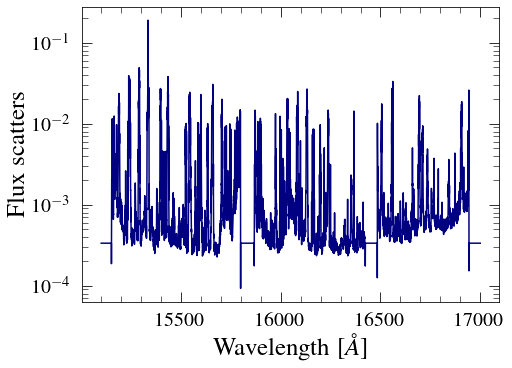

In [9]:

plt.figure(figsize=(7,5), constrained_layout=True)

plt.plot(spectra_data['wl'], jnp.exp(ln_noise_fluxes_updated), color='navy')
plt.ylabel('Flux scatters', fontsize=25)
plt.xlabel('Wavelength [$\AA$]', fontsize=25)
plt.yscale('log')
# plt.ylim(0,0.02)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/noise_fluxes_train_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')